In [1]:
import os, sys
import torch
import matplotlib.pyplot as plt
from PIL import Image
sys.path.append('./perception_models')
import core.vision_encoder.pe as pe
import core.vision_encoder.transforms as transforms
from huggingface_hub import hf_hub_download
import cv2
def preprocess_video(video_path, num_frames=8, transform=None, return_first_frame_for_demo=True):
    print(video_path)
    cap = cv2.VideoCapture(video_path, apiPreference=cv2.CAP_ANY)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    frame_indices = [int(i * (total_frames / num_frames)) for i in range(num_frames)]
    preprocessed_frames = []
    first_frame = None

    current_index = 0
    grabbed_index = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        if current_index == frame_indices[grabbed_index]:
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            pil_img = Image.fromarray(frame_rgb)
            if transform:
                frame_tensor = transform(pil_img)
            else:
                frame_tensor = transforms.ToTensor()(pil_img)

            preprocessed_frames.append(frame_tensor)

            if grabbed_index == 0 and return_first_frame_for_demo:
                first_frame = frame_rgb

            grabbed_index += 1
            if grabbed_index >= len(frame_indices):
                break

        current_index += 1

    cap.release()
    return torch.stack(preprocessed_frames, dim=0), first_frame

local_ckpt_path = hf_hub_download(
    repo_id="facebook/PE-Core-B16-224",
    filename="PE-Core-B16-224.pt"
)
device = torch.device("mps")
model_name = 'PE-Core-B16-224'

model = pe.CLIP.from_config(model_name, pretrained=True, checkpoint_path=local_ckpt_path)
model = model.to(device)

preprocess = transforms.get_image_transform(model.image_size)
tokenizer = transforms.get_text_tokenizer(model.context_length)

Missing keys for loading model: []
Unexpected keys for loading model: []


/Users/michaelrice/Documents/GitHub/Thesis/MSc_AI_Thesis/sampledata/vid_test/output_video.mp4


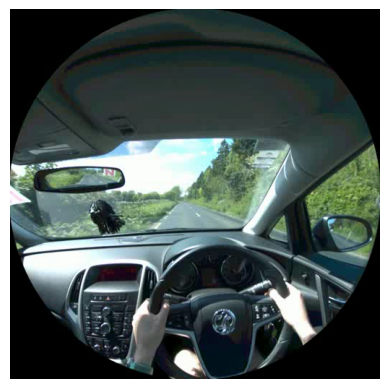

Captions: ['a blue car', 'a red car', 'a black car']
Label probs: 0.22 0.19 0.59
This video is about a black car


In [6]:
video, first_frame = preprocess_video("/Users/michaelrice/Documents/GitHub/Thesis/MSc_AI_Thesis/sampledata/vid_test/output_video.mp4", 8, transform=preprocess)
video = video.unsqueeze(0).to(device)
text = tokenizer(["a blue car", "a red car", "a black car"]).to(device)
captions = ["a blue car", "a red car", "a black car"]

with torch.no_grad():
    image_features = model.encode_video(video)
    text_features = model.encode_text(text)
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1).cpu().numpy()[0]

plt.imshow(Image.fromarray(first_frame))
plt.axis('off')
plt.show()
print("Captions:", captions)
print("Label probs:", ' '.join(['{:.2f}'.format(prob) for prob in text_probs]))  # prints: [[0.00, 1.00, 0.00]]
print(f"This video is about {captions[text_probs.argmax()]}")

In [8]:
from transformers import AutoTokenizer, AutoModel

model_id = "facebook/Perception-LM-8B"  # or the correct path
tokenizer = AutoTokenizer.from_pretrained(model_id, token=True)
model = AutoModel.from_pretrained(model_id, token=True)


ValueError: Unrecognized model in facebook/Perception-LM-8B. Should have a `model_type` key in its config.json, or contain one of the following strings in its name: albert, align, altclip, aria, aria_text, audio-spectrogram-transformer, autoformer, aya_vision, bamba, bark, bart, beit, bert, bert-generation, big_bird, bigbird_pegasus, biogpt, bit, blenderbot, blenderbot-small, blip, blip-2, bloom, bridgetower, bros, camembert, canine, chameleon, chinese_clip, chinese_clip_vision_model, clap, clip, clip_text_model, clip_vision_model, clipseg, clvp, code_llama, codegen, cohere, cohere2, colpali, conditional_detr, convbert, convnext, convnextv2, cpmant, ctrl, cvt, dab-detr, dac, data2vec-audio, data2vec-text, data2vec-vision, dbrx, deberta, deberta-v2, decision_transformer, deformable_detr, deit, depth_anything, depth_pro, deta, detr, diffllama, dinat, dinov2, dinov2_with_registers, distilbert, donut-swin, dpr, dpt, efficientformer, efficientnet, electra, emu3, encodec, encoder-decoder, ernie, ernie_m, esm, falcon, falcon_mamba, fastspeech2_conformer, flaubert, flava, fnet, focalnet, fsmt, funnel, fuyu, gemma, gemma2, gemma3, gemma3_text, git, glm, glpn, got_ocr2, gpt-sw3, gpt2, gpt_bigcode, gpt_neo, gpt_neox, gpt_neox_japanese, gptj, gptsan-japanese, granite, granitemoe, granitemoeshared, granitevision, graphormer, grounding-dino, groupvit, helium, hiera, hubert, ibert, idefics, idefics2, idefics3, idefics3_vision, ijepa, imagegpt, informer, instructblip, instructblipvideo, jamba, jetmoe, jukebox, kosmos-2, layoutlm, layoutlmv2, layoutlmv3, led, levit, lilt, llama, llava, llava_next, llava_next_video, llava_onevision, longformer, longt5, luke, lxmert, m2m_100, mamba, mamba2, marian, markuplm, mask2former, maskformer, maskformer-swin, mbart, mctct, mega, megatron-bert, mgp-str, mimi, mistral, mistral3, mixtral, mllama, mobilebert, mobilenet_v1, mobilenet_v2, mobilevit, mobilevitv2, modernbert, moonshine, moshi, mpnet, mpt, mra, mt5, musicgen, musicgen_melody, mvp, nat, nemotron, nezha, nllb-moe, nougat, nystromformer, olmo, olmo2, olmoe, omdet-turbo, oneformer, open-llama, openai-gpt, opt, owlv2, owlvit, paligemma, patchtsmixer, patchtst, pegasus, pegasus_x, perceiver, persimmon, phi, phi3, phimoe, pix2struct, pixtral, plbart, poolformer, pop2piano, prompt_depth_anything, prophetnet, pvt, pvt_v2, qdqbert, qwen2, qwen2_5_vl, qwen2_audio, qwen2_audio_encoder, qwen2_moe, qwen2_vl, rag, realm, recurrent_gemma, reformer, regnet, rembert, resnet, retribert, roberta, roberta-prelayernorm, roc_bert, roformer, rt_detr, rt_detr_resnet, rt_detr_v2, rwkv, sam, seamless_m4t, seamless_m4t_v2, segformer, seggpt, sew, sew-d, shieldgemma2, siglip, siglip2, siglip_vision_model, smolvlm, smolvlm_vision, speech-encoder-decoder, speech_to_text, speech_to_text_2, speecht5, splinter, squeezebert, stablelm, starcoder2, superglue, superpoint, swiftformer, swin, swin2sr, swinv2, switch_transformers, t5, table-transformer, tapas, textnet, time_series_transformer, timesformer, timm_backbone, timm_wrapper, trajectory_transformer, transfo-xl, trocr, tvlt, tvp, udop, umt5, unispeech, unispeech-sat, univnet, upernet, van, video_llava, videomae, vilt, vipllava, vision-encoder-decoder, vision-text-dual-encoder, visual_bert, vit, vit_hybrid, vit_mae, vit_msn, vitdet, vitmatte, vitpose, vitpose_backbone, vits, vivit, wav2vec2, wav2vec2-bert, wav2vec2-conformer, wavlm, whisper, xclip, xglm, xlm, xlm-prophetnet, xlm-roberta, xlm-roberta-xl, xlnet, xmod, yolos, yoso, zamba, zamba2, zoedepth